<a href="https://colab.research.google.com/github/G10v4l4rc0n/Tarea2_MachineLearning/blob/main/Tarea_2_ML_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importación de librerías

In [1]:
!pip install -q ucimlrepo scikit-learn numpy pandas matplotlib seaborn requests

In [2]:
#Trabajos miscelaneos o de un solo uso
import requests
import zipfile
import io
import re
from ucimlrepo import fetch_ucirepo

#Tratamiento y visualización de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Modelos y entrenamiento
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, make_scorer, adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import pair_confusion_matrix, contingency_matrix
from sklearn.preprocessing import StandardScaler

#Dimensionalidad
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#TenserFlow (Autoencoder)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers

# Semillas

### Descargar dataset de semillas

In [3]:
url = "https://archive.ics.uci.edu/static/public/236/seeds.zip"
response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall()  # Extrae todo en el directorio actual

### Transformar dataset a pandas dataframe
Para el correcto trabajo de este dataset transformaremos el archivo de texto a un dataframe de Pandas

In [4]:
######IMPORTACIÓN Y TRANSFORMACIÓN DE DATASET A DATAFRAME
#IMPORTACIÓN
with open("seeds_dataset.txt", 'r') as file:
    data_list = re.split('\t|\n', file.read())

#TRANSFORMACIÓN A LISTA
copy = data_list.copy()
for value in copy:
    try:
        index_to_remove = copy.index('')
    except:
        break
    else:
        copy.remove('')

for index in range(len(copy)):
    copy[index] = float(copy[index])

#TRANSFORMACIÓN A DATAFRAME
final_list, sub_list = [], []
cont = 0;
for i in range(210):
    final_list.append(copy[8*i:8*(i+1)])

#Revisar si la nueva lista tiene los valores correctos
"""
for val in final_list[:5]:
    print(val)
"""

data ={
    "area": [],
    "perimeter": [],
    "compactness": [],
    "length of kernel": [],
    "width of kernel": [],
    "asymmetry coefficient": [],
    "length of kernel groove": [],
    "classification": []
}
for sub_list in final_list:
    data["area"].append(sub_list[0])
    data["perimeter"].append(sub_list[1])
    data["compactness"].append(sub_list[2])
    data["length of kernel"].append(sub_list[3])
    data["width of kernel"].append(sub_list[4])
    data["asymmetry coefficient"].append(sub_list[5])
    data["length of kernel groove"].append(sub_list[6])
    data["classification"].append(sub_list[7])
#print(df)

#Asignación de tipos a las variables
df_dtypes = {
    "area": float,
    "perimeter": float,
    "compactness": float,
    "length of kernel": float,
    "width of kernel": float,
    "asymmetry coefficient": float,
    "length of kernel groove": float,
    "classification": int
}

df = pd.DataFrame(data).astype(df_dtypes)

In [5]:
# Escalamos los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

### Reducción de dimensión

En esta sección del codigo es cuando estuvimos probando los diferentes metodos de redimencionamiento de los datos con nuestro Dataset, donde buscaríamos evaluar si a primeras impresiones cual era la mejor forma de aplicarlos.

### PCA

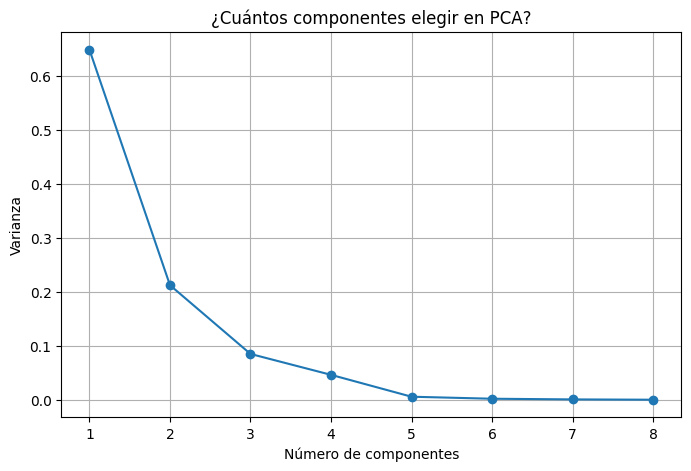

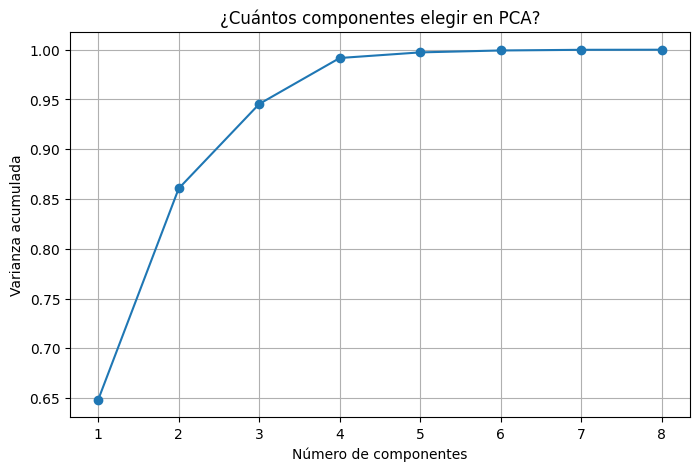

In [6]:
# Aplicamos PCA sin limitar componentes (usa todos)
pca = PCA()
pca.fit(X_scaled)

# Varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Varianza acumulada
cumulative_variance = np.cumsum(explained_variance)

# Grafico Varianza
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza')
plt.title('¿Cuántos componentes elegir en PCA?')
plt.grid(True)
plt.show()

# Gráfico Varianza Acumulada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.title('¿Cuántos componentes elegir en PCA?')
plt.grid(True)
plt.show()

Con el codigo anterior se puede ver que aplicamos un modelo PCA sin una especificación de parametros, lo que resultara que se apliquen la cantidad total o existentes de componentes con PCA, que al evaluar con la varianza, se puede ver cuanta información tiene N cantidad de paramatros. En este punto escogimos que de 2 a 3 componentes eran los ideales conteniendo 86% y 95% de la información respectivamente.

### t-SNE

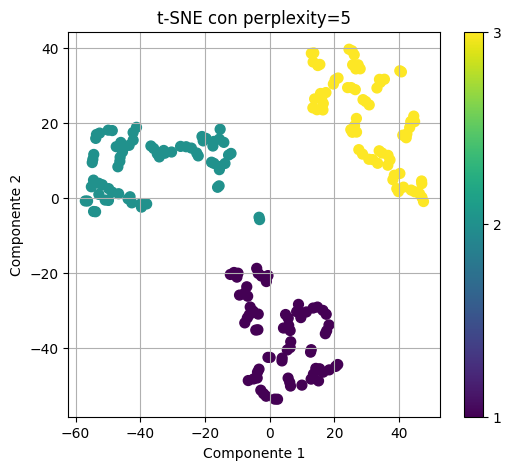

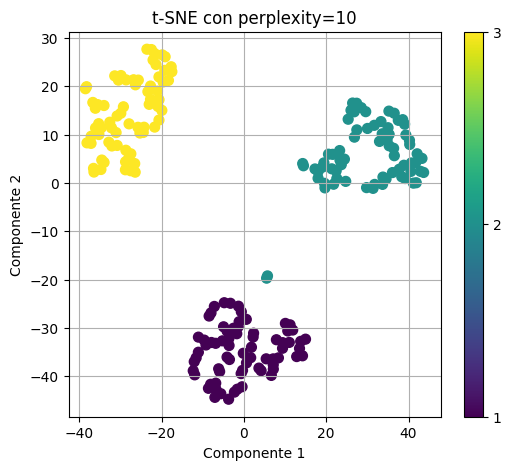

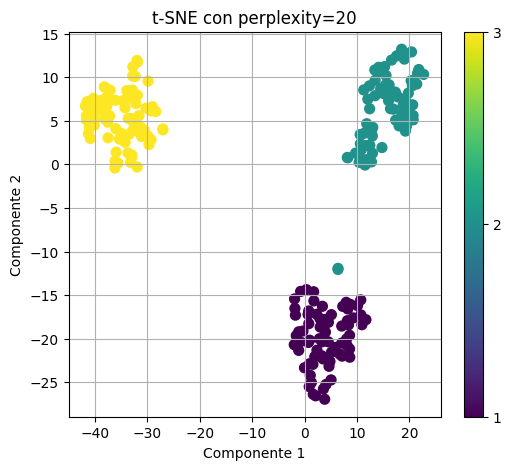

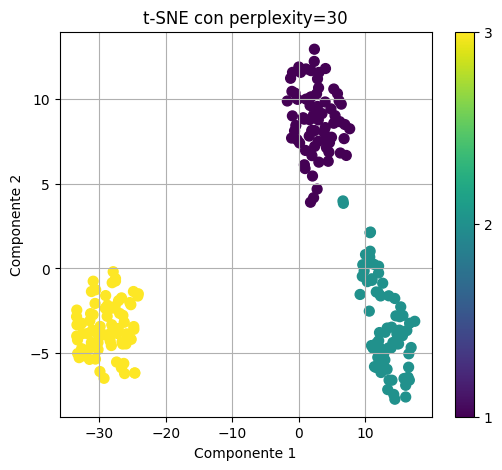

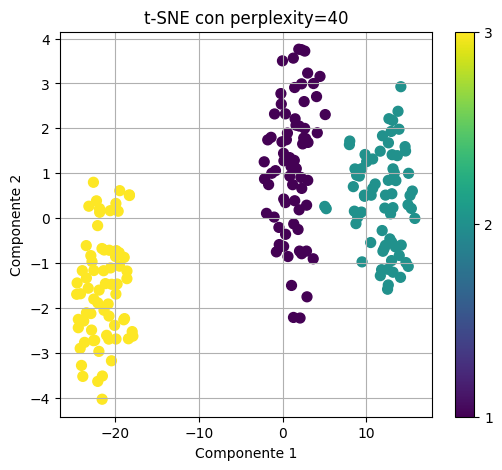

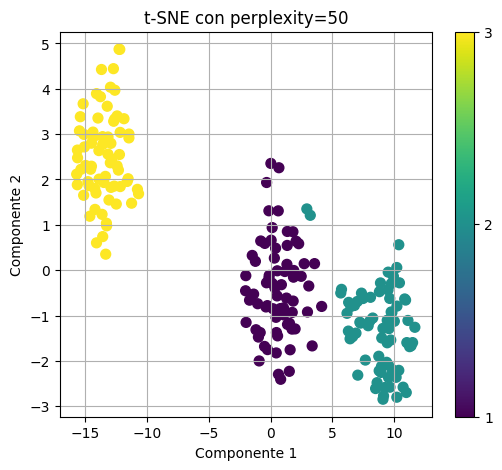

In [7]:
perplexities = [5, 10, 20, 30, 40, 50]

for p in perplexities:
    tsne = TSNE(n_components=2, perplexity=p, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)

    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['classification'], cmap='viridis', s=50)
    plt.title(f't-SNE con perplexity={p}')
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.colorbar(scatter, ticks=[1, 2, 3])
    plt.grid(True)
    plt.show()

Con respecto al codigo anterior. t-SNE a diferencia de PCA, si bien se pueden especificar una cantidad de parametros, realmente no es un factor tan determinante como lo es Perplexity (Perplejidad), donde lo recomendable hasta donde hemos leído es entre 20 y 30 para 2 parametros (Los que usamos). Las interpretaciones o evaluaciones de t-SNE son más subjetivas y no hay una varianza que determine de manera exacta un valor, por lo anterior, visualmente creemos que una perplexity entre 40, 50 se ven mejor.

### Autoencoder

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 1.0124
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9329
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8189
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6817 
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5472
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4243
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3338
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2776  
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2443
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2215
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2037
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1886  
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1765  
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1659 
Epoch 15/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss:

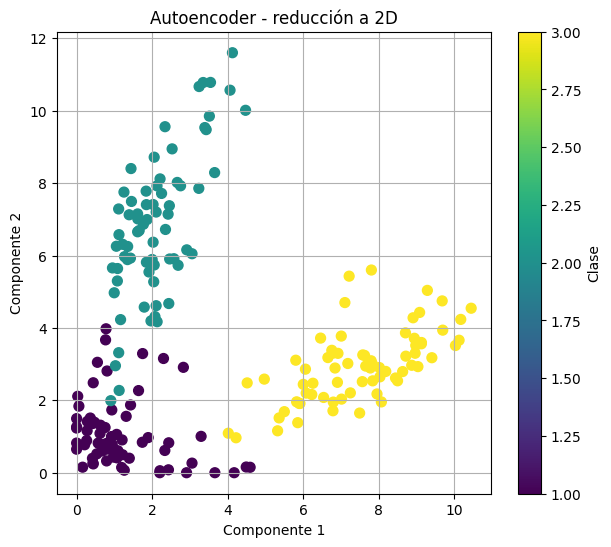

In [8]:
import random
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)


input_dim = X_scaled.shape[1]
encoding_dim = 2

# Definimos las capas
  # Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(16, activation='relu')(encoded)
encoded = Dense(2, activation='relu', activity_regularizer=regularizers.l1(1e-5))(encoded)

  # Decoder
decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)

# Modelos
autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)

# Compilar
autoencoder.compile(optimizer='adam', loss='mse')

# Entrenamiento.
autoencoder.fit(X_scaled, X_scaled, epochs=100, batch_size=16, shuffle=True, verbose=1)

# Datos reducidos
X_encoded = encoder.predict(X_scaled)

# Visualización
plt.figure(figsize=(7, 6))
plt.scatter(X_encoded[:, 0], X_encoded[:, 1], c=df['classification'], cmap='viridis', s=50)
plt.title("Autoencoder - reducción a 2D")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.colorbar(label="Clase")
plt.grid(True)
plt.show()

Respecto al codigo anterior. Autoencoder genera distintas dimensionalidades bastante variadas según la seed, donde no quisimos meternos debido a que no sabríamos tratar este metodo.

## Clusters sin reducción de dimensionalidad
Realizamos búsqueda de grilla para KMeans, DBScan y agrupamiento jerárquico (Agglomerative Clustering), con la finalidad de tener un punto de comparación para poder desarrollar conclusiones, todos los modelos utilizaron de métrica el puntaje de silueta (Silhouette score).

In [9]:
######CLUSTERIZACIÓN INICIAL SIN PREPROCESAMIENTO

#mezclar dataframe
df = df.sample(frac=1, random_state=42)

### KMeans
Para el algoritmo de KMeans definimos la grilla con los siguientes valores:


*   **n_clusters**: la cantidad de centroides deseados.
*   **init**: el tipo de inicialización de los centroides.
*   **n_init**: la cantidad de veces que se ejecuta el algoritmo usando semillas de centroides distintas.




In [10]:
#KMEANS

kmeans = KMeans()
param_grid = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'init': ['k-means++', 'random'],
    'n_init': ['auto', 1, 10, 100],
}

grid_kmeans = GridSearchCV(estimator=kmeans, param_grid=param_grid)
grid_kmeans.fit(df)

GridSearchCV(estimator=KMeans(),
             param_grid={'init': ['k-means++', 'random'],
                         'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_init': ['auto', 1, 10, 100]})

In [11]:
print(silhouette_score(df, grid_kmeans.best_estimator_.labels_))
print(grid_kmeans.best_params_)

0.3564874757367297
{'init': 'k-means++', 'n_clusters': 10, 'n_init': 'auto'}


KMeans nos entrega un puntaje silueta del 35%, esto quiere decir que los puntos están más cerca de las fronteras que de sus centroides.

### DBScan
Para el algoritmo de DBScan establecemos la grilla de parámetros con los siguientes valores:
*   **eps**: la distancia máxima para que dos puntos se consideren vecinos el uno del otro.
*   **min_samples**: número de puntos vecinos que requiere un punto para ser considerado punto núcleo.
*   **metric**: la métrica a utilizar para calcular la distancia entre dos puntos.
*   **algorithm**: el algoritmo usado para calcular las distancias puntuales y encontrar los vecinos más cercanos.
*   **leaf_size**: la cantidad de 'hojas' utilizadas por los algoritmos 'ball_tree' y 'kd_tree'.
*   **p**: la potencia a elevar al usar la métrica de 'minkowsky'.
*   **n_jobs**: la cantidad de procesos a realizar al mismo tiempo.

In [12]:
#DBSCAN
def DBSCAN_Grid_Search(df):
  param_grid = [
    {
        'eps': [0.01, 0.1, 0.5, 0.9],
        'min_samples': [5, 10, 15],
        'metric': ['cityblock', 'euclidean', 'l1', 'l2', 'manhattan'],
        'algorithm': ['ball_tree', 'kd_tree'],
        'leaf_size': [30, 100, 1000],
        'n_jobs': [2]
    },
    {
        'eps': [0.01, 0.1, 0.5, 0.9],
        'min_samples': [5, 10, 15],
        'metric': ['minkowski'],
        'p': [2, 3, 4, 5],
        'algorithm': ['ball_tree', 'kd_tree'],
        'leaf_size': [30, 100, 1000],
        'n_jobs': [2]
    },
    {
        'eps': [0.01, 0.1, 0.5, 0.9],
        'min_samples': [5, 10, 15],
        'metric': ['cityblock', 'euclidean', 'l1', 'l2', 'manhattan'],
        'algorithm': ['brute'],
        'n_jobs': [2]
    },
    {
        'eps': [0.01, 0.1, 0.5, 0.9],
        'min_samples': [5, 10, 15],
        'metric': ['minkowski'],
        'p': [2, 3, 4, 5],
        'algorithm': ['brute'],
        'n_jobs': [2]
    }
  ]

  dbscan = DBSCAN()
  scores = []

#Grid search
  for dic in param_grid:
    if len(dic['algorithm']) == 1: #brute algorithm
      if len(dic['metric']) > 1: #not minkowsky metric
        for eps in dic['eps']:
          for min_samples in dic['min_samples']:
            for metric in dic['metric']:
              params = {'eps': eps, 'min_samples': min_samples, 'metric': metric, 'algorithm': 'brute', 'n_jobs': 2}
              dbscan.set_params(**params)
              dbscan.fit(df)
              if len(np.unique(dbscan.labels_)) > 1:
                score_params_pair = [silhouette_score(df, dbscan.labels_), params]
                scores.append(score_params_pair)
              else:
                score_params_pair = [-1, params]
                scores.append(score_params_pair)
      else: #minkowsky metric in brute algorithm
        for eps in dic['eps']:
          for min_samples in dic['min_samples']:
            for metric in dic['metric']:
              for p in dic['p']:
                params = {'eps': eps, 'min_samples': min_samples, 'metric': metric, 'p': p, 'algorithm': 'brute', 'n_jobs': 2}
                dbscan.set_params(**params)
                dbscan.fit(df)
                if len(np.unique(dbscan.labels_)) > 1:
                  score_params_pair = [silhouette_score(df, dbscan.labels_), params]
                  scores.append(score_params_pair)
                else:
                  score_params_pair = [-1, params]
                  scores.append(score_params_pair)
    else: #not brute algorithm
      if len(dic['metric']) == 1: #minkowsky metric
        for eps in dic['eps']:
          for min_samples in dic['min_samples']:
            for p in dic['p']:
              for algorithm in dic['algorithm']:
                for leaf_size in dic['leaf_size']:
                  params = {'eps': eps, 'min_samples': min_samples, 'metric': 'minkowski', 'p': p, 'algorithm': algorithm, 'leaf_size': leaf_size, 'n_jobs': 2}
                  dbscan.set_params(**params)
                  dbscan.fit(df)
                  if len(np.unique(dbscan.labels_)) > 1:
                    score_params_pair = [silhouette_score(df, dbscan.labels_), params]
                    scores.append(score_params_pair)
                  else:
                    score_params_pair = [-1, params]
                    scores.append(score_params_pair)
      else: #not minkowsy on not brute algorithm
        for eps in dic['eps']:
          for min_samples in dic['min_samples']:
            for metric in dic['metric']:
              for algorithm in dic['algorithm']:
                for leaf_size in dic['leaf_size']:
                  params = {'eps': eps, 'min_samples': min_samples, 'metric': metric, 'algorithm': algorithm, 'leaf_size': leaf_size, 'n_jobs': 2}
                  dbscan.set_params(**params)
                  dbscan.fit(df)
                  if len(np.unique(dbscan.labels_)) > 1:
                    score_params_pair = [silhouette_score(df, dbscan.labels_), params]
                    scores.append(score_params_pair)
                  else:
                    score_params_pair = [-1, params]
                    scores.append(score_params_pair)
  best_score = pd.DataFrame(scores).sort_values(by=0, ascending=False).head(1).values[0][0]
  best_params = pd.DataFrame(scores).sort_values(by=0, ascending=False).head(1).values[0][1]
  return best_score, best_params

In [13]:
print(f"best score: {DBSCAN_Grid_Search(df)[0]}")
print(f"best params: {DBSCAN_Grid_Search(df)[1]}")

best score: 0.3949450728271234
best params: {'eps': 0.9, 'min_samples': 5, 'metric': 'minkowski', 'p': 4, 'algorithm': 'brute', 'n_jobs': 2}


DBScan obtiene una puntuación del 39% casi 40% en puntaje silueta, sigue siendo un puntaje que denota mayor cercanía hacia los bordes que hacia los núcleos.

### Agrupamiento jerárquico
Para el agrupamiento jerárquico se establecieron los siguientes parámetros:
*   **n_clusters**: la cantidad de centroides.
*   **metric**: la forma de calcular la distancia entre puntos.
*   **linkage**: el criterio de conexión entre pares de observaciones.
*   **compute_distances**: establece si se calculan las distancias, esto sirve para generar dendrogramas.

In [14]:
#Hierarchical (agglomerative)
def HIER_gridsearch(df):
  param_grid = [
    {
        'n_clusters': [2, 3, 4, 5, 10],
        'metric': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],
        'linkage': ['complete', 'average', 'single'],
        'compute_distances': [True]
    },
    {
        'n_clusters': [2, 3, 4, 5, 10],
        'metric': ['euclidean'],
        'linkage': ['ward'],
        'compute_distances': [True]
    },
  ]

  hier = AgglomerativeClustering()
  scores = []
  for dic in param_grid:
    if len(dic['metric']) > 1:
      for n_clusters in dic['n_clusters']:
        for metric in dic['metric']:
          for linkage in dic['linkage']:
            params = {'n_clusters': n_clusters, 'metric': metric, 'linkage': linkage, 'compute_distances': True}
            hier.set_params(**params)
            hier.fit(df)
            if len(np.unique(hier.labels_)) > 1:
              score_params_pair = [silhouette_score(df, hier.labels_), params]
              scores.append(score_params_pair)
            else:
              score_params_pair = [-1, params]
              scores.append(score_params_pair)
    else:
      for n_clusters in dic['n_clusters']:
        params = {'n_clusters': n_clusters, 'metric': 'euclidean', 'linkage': 'ward', 'compute_distances': True}
        hier.set_params(**params)
        hier.fit(df)
        if len(np.unique(hier.labels_)) > 1:
          score_params_pair = [silhouette_score(df, hier.labels_), params]
          scores.append(score_params_pair)
        else:
          score_params_pair = [-1, params]
          scores.append(score_params_pair)
  best_score = pd.DataFrame(scores).sort_values(by=0, ascending=False).head(1).values[0][0]
  best_params = pd.DataFrame(scores).sort_values(by=0, ascending=False).head(1).values[0][1]
  return best_score, best_params

In [15]:
print(f"best score: {HIER_gridsearch(df)[0]}")
print(f"best params: {HIER_gridsearch(df)[1]}")

best score: 0.49334215467963544
best params: {'n_clusters': 2, 'metric': 'l1', 'linkage': 'complete', 'compute_distances': True}


Agrupación jerárquica obtuvo un 49% de puntaje silueta, es mejor que los dos anteriores pero aún no es un resultado convincente.

## Clusters con reducción de dimensionalidad
A continuación se volverán a ejecutar los algoritmos de agrupación con sus respectivas búsquedas de grilla, pero aplicando una reducción de dimensionalidad para poder ver una representación gráfica de los resultados.

### PCA
El algoritmo PCA es similar a tomar la muestra con todas las dimensiones y aplastarla hasta la cantidad de dimensiones deseadas, en este caso 2 dimensiones.

#### DBScan - PCA

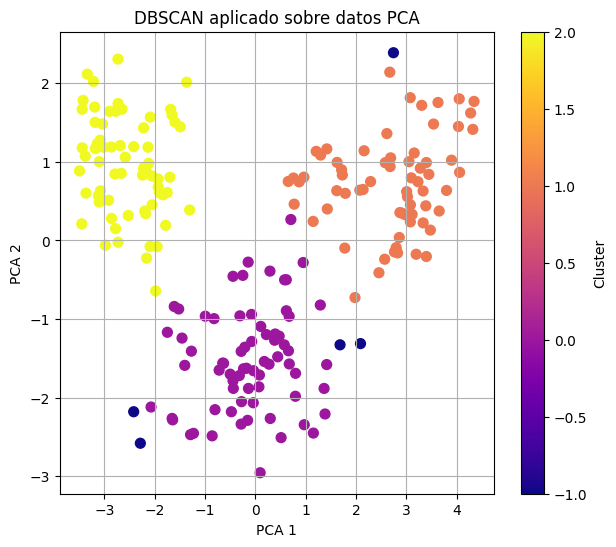

Silhouette Score: 0.613


In [16]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
params = DBSCAN_Grid_Search(X_pca)[1]
labels = DBSCAN(**params).fit_predict(X_pca)

plt.figure(figsize=(7, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='plasma', s=50)
plt.title("DBSCAN aplicado sobre datos PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()

mask = labels != -1  # descarta puntos considerados ruido
score = silhouette_score(X_pca[mask], labels[mask])
print(f"Silhouette Score: {score:.3f}")

El algoritmo DBScan generó 3 centroides y detectó unas observaciones de ruido, a simple vista se ven bien separados los grupos, con algunas observaciones que dejan un pequeño lugar a dudas.
El puntaje silueta esta vez fue del 61%, una mejoría notoria respecto a ejecutar el mismo algoritmo sin reducir la dimensionalidad.

#### KMeans - PCA

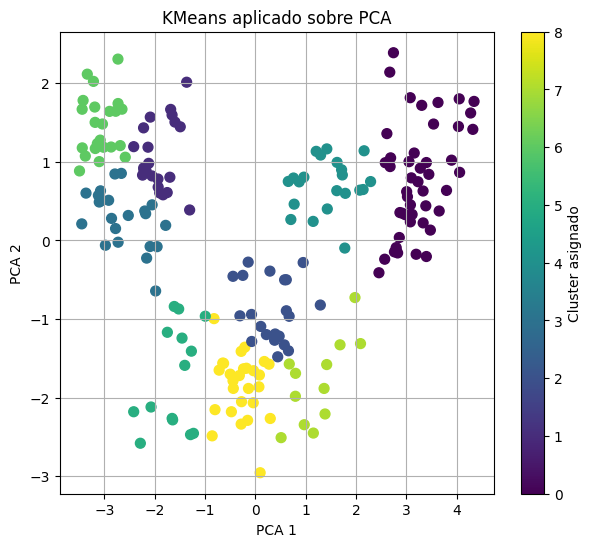

Silhouette Score: 0.403


In [17]:
kmeans = KMeans()
param_grid = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'init': ['k-means++', 'random'],
    'n_init': ['auto', 1, 10, 100],
}

grid_kmeans = GridSearchCV(estimator=kmeans, param_grid=param_grid)
grid_kmeans.fit(X_pca)
labels = grid_kmeans.best_estimator_.labels_

plt.figure(figsize=(7, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50)
plt.title("KMeans aplicado sobre PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster asignado")
plt.grid(True)
plt.show()

score = silhouette_score(X_pca, labels)
print(f"Silhouette Score: {score:.3f}")

El algoritmo KMeans sigue teniendo un rendimiento de menor cálidad respecto a los otros algoritmos, estableciendo muchos centroides y obteniendo un puntaje silueta del 40%.

#### Agrupamiento jerárquico - PCA

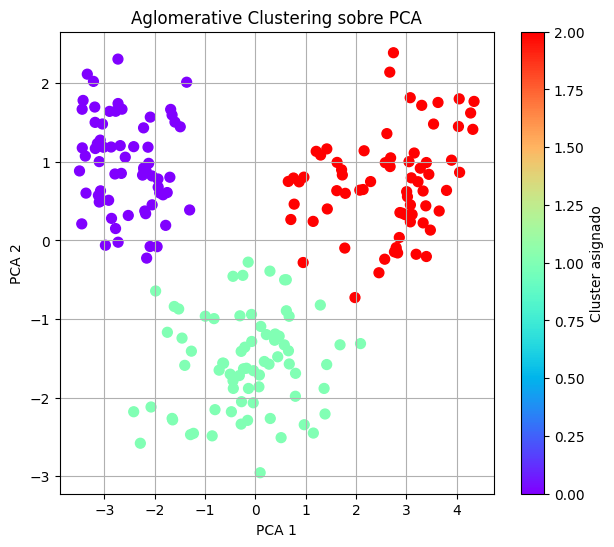

Silhouette Score: 0.600


In [18]:
params = HIER_gridsearch(X_pca)[1]
labels = AgglomerativeClustering(**params).fit_predict(X_pca)

"""
agglo = AgglomerativeClustering(n_clusters=3)
labels = agglo.fit_predict(X_pca)
"""

plt.figure(figsize=(7, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='rainbow', s=50)
plt.title("Aglomerative Clustering sobre PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster asignado")
plt.grid(True)
plt.show()

score = silhouette_score(X_pca, labels)
print(f"Silhouette Score: {score:.3f}")

Hasta ahora el segundo mejor algoritmo con PCA, el agrupamiento jerárquico, con un 60% de puntaje silueta y una clara separación en los grupos al visualizarlos en el gráfico.

### t-SNE
La reducción de dimensionalidad por t-SNE busca separar lo más posible las observaciones prevaleciendo las relaciones intragrupales por semejanza de atributos.

#### DBScan - t-SNE

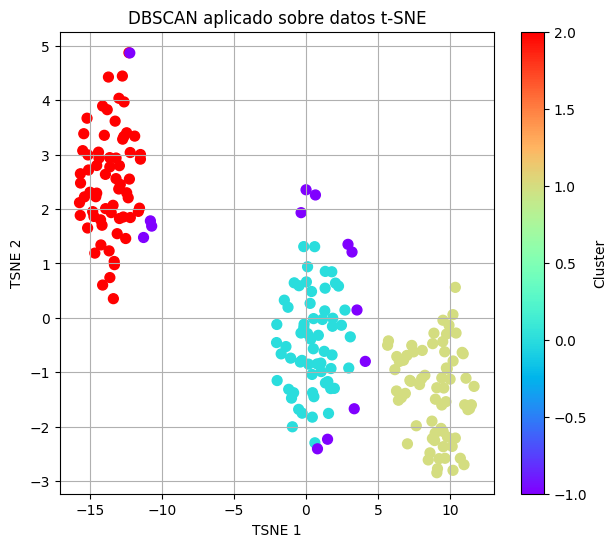

Silhouette Score: 0.788


In [19]:
scores = []
for perplexity in [10, 20, 30, 40, 50]:
  tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
  X_tsne = tsne.fit_transform(X_scaled)
  params = DBSCAN_Grid_Search(X_tsne)[1]
  labels = DBSCAN(**params).fit_predict(X_tsne)
  if len(np.unique(labels)) > 1:
    perplexity_score = silhouette_score(X_tsne, labels)
  else:
    perplexity_score = -1
  scores.append([perplexity, params, perplexity_score])

best_score = pd.DataFrame(scores).sort_values(by=2, ascending=False).head(1).values[0][0]
best_params = pd.DataFrame(scores).sort_values(by=2, ascending=False).head(1).values[0][1]
tsne = TSNE(n_components=2, perplexity=best_score, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
labels = DBSCAN(**best_params).fit_predict(X_tsne)

plt.figure(figsize=(7, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='rainbow', s=50)
plt.title("DBSCAN aplicado sobre datos t-SNE")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()

mask = labels != -1  # descarta puntos considerados ruido
score = silhouette_score(X_tsne[mask], labels[mask])
print(f"Silhouette Score: {score:.3f}")

In [20]:
print(f"best perplexity: {best_score}")
print(f"best params: {best_params}")

best perplexity: 50
best params: {'eps': 0.9, 'min_samples': 10, 'metric': 'minkowski', 'p': 5, 'algorithm': 'brute', 'n_jobs': 2}


El algoritmo DBScan nuevamente presenta una mejoría llegando a un 78% casi 79% de puntaje silueta, además se puede apreciar con mayor claridad en el gráfico los grupos generados, y se ven más uniformes las observaciones que se consideran ruido.

#### KMeans - t-SNE

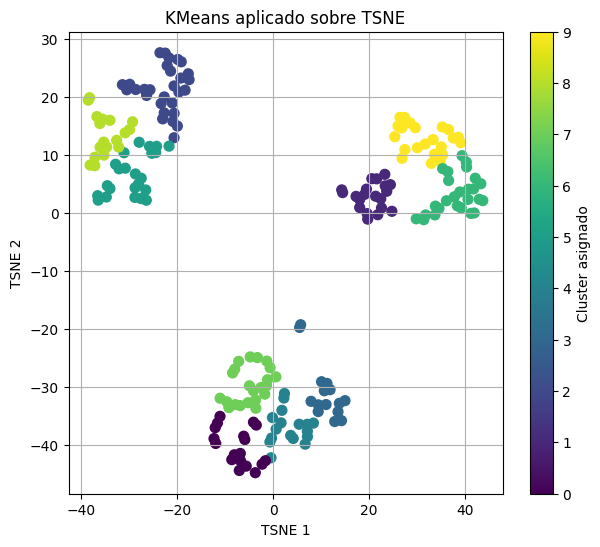

Silhouette Score: 0.444


In [21]:
kmeans = KMeans()
param_grid = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'init': ['k-means++', 'random'],
    'n_init': ['auto', 1, 10, 100],
}

scores = []
for perplexity in [10, 20, 30, 40, 50]:
  tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
  X_tsne = tsne.fit_transform(X_scaled)
  grid_kmeans = GridSearchCV(estimator=kmeans, param_grid=param_grid)
  grid_kmeans.fit(X_tsne)
  if len(np.unique(grid_kmeans.best_estimator_.labels_)) > 1:
    perplexity_score = silhouette_score(X_tsne, grid_kmeans.best_estimator_.labels_)
  else:
    perplexity_score = -1
  scores.append([perplexity, grid_kmeans.best_params_, perplexity_score])

best_perplexity = pd.DataFrame(scores).sort_values(by=2, ascending=False).head(1).values[0][0]
best_params = pd.DataFrame(scores).sort_values(by=2, ascending=False).head(1).values[0][1]
tsne = TSNE(n_components=2, perplexity=best_perplexity, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
labels = KMeans(**best_params).fit_predict(X_tsne)

plt.figure(figsize=(7, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=50)
plt.title("KMeans aplicado sobre TSNE")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.colorbar(label="Cluster asignado")
plt.grid(True)
plt.show()

score = silhouette_score(X_tsne, labels)
print(f"Silhouette Score: {score:.3f}")

In [22]:
print(f"best perplexity: {best_perplexity}")
print(f"best params: {best_params}")

best perplexity: 10
best params: {'init': 'random', 'n_clusters': 10, 'n_init': 100}


El algoritmo KMeans en definitiva no es el mejor candidato a este problema, al obtener un puntaje de tan solo el 44% de puntaje silueta y sin demostrar una separación notoria.

#### Agrupamiento jerárquico - t-SNE

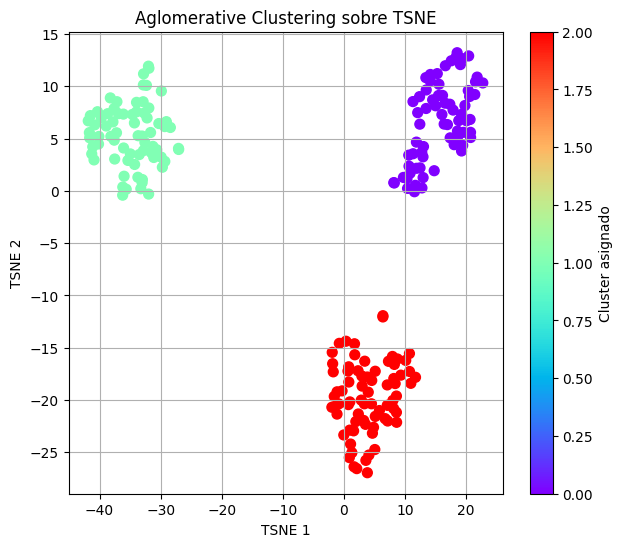

Silhouette Score: 0.801


In [23]:
scores = []
for perplexity in [10, 20, 30, 40, 50]:
  tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
  X_tsne = tsne.fit_transform(X_scaled)
  params = HIER_gridsearch(X_tsne)[1]
  labels = AgglomerativeClustering(**params).fit_predict(X_tsne)
  if len(np.unique(labels)) > 1:
    perplexity_score = silhouette_score(X_tsne, labels)
  else:
    perplexity_score = -1
  scores.append([perplexity, params, perplexity_score])

best_perplexity = pd.DataFrame(scores).sort_values(by=2, ascending=False).head(1).values[0][0]
best_params = pd.DataFrame(scores).sort_values(by=2, ascending=False).head(1).values[0][1]
tsne = TSNE(n_components=2, perplexity=best_perplexity, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
labels = AgglomerativeClustering(**best_params).fit_predict(X_tsne)

plt.figure(figsize=(7, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='rainbow', s=50)
plt.title("Aglomerative Clustering sobre TSNE")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.colorbar(label="Cluster asignado")
plt.grid(True)
plt.show()

score = silhouette_score(X_tsne, labels)
print(f"Silhouette Score: {score:.3f}")

In [24]:
print(f"best perplexity: {best_perplexity}")
print(f"best params: {best_params}")

best perplexity: 20
best params: {'n_clusters': 3, 'metric': 'euclidean', 'linkage': 'complete', 'compute_distances': True}


El mejor algoritmo en definitiva fue el agrupamiento jerárquico post reducción de dimensionalidad t-SNE obteniendo un puntaje silueta del 80% y demostrando notoriamente la correcta separación de los grupos.

##Conclusión
Con respecto al primer Dataset, estamos bastante conformes con los resultados, pues si bien aplicamos 2 de los 3 metodos de "reducción de dimensión" de los vistos en clases, al realizar la clusterización previa y post al uso de los metodos, nos dieron unos resultados bastante altos, donde destacamos el uso de hiperparametros aumentaron los porcentajes en grandes medidas.

Con respecto a la medición del Silouette, creo que se ajusta bastante a lo que esperamos y porque nos dan porcentajes tan altos, pues contamos con 3 tipos de semillas, que al separar 3 clusters, se reparten bien los datos.

#Billetes

## 1. Obtener Dataset de billetes falsos

Este dataset contiene características estadísticas extraídas de imágenes de billetes escaneados. El objetivo es clasificar si un billete es auténtico (0) o falso (1).

In [25]:
# fetch dataset
banknote_authentication = fetch_ucirepo(id=267)

# data (as pandas dataframes)
X = banknote_authentication.data.features
y = banknote_authentication.data.targets

## 2. Exploración de datos



Variables:
- **variance**: Varianza de la imagen procesada. Mide cuánto varían los píxeles (más varianza = más contraste).
- **skewness**: Asimetría de la distribución de intensidades. Mide si los datos están cargados hacia un lado.
- **curtosis**: Curtosis de la distribución. Mide si la distribución tiene colas pesadas o es más aplanada.
- **entropy**: Entropía de la imagen. Mide el grado de desorden o complejidad.

In [26]:
banknote = pd.DataFrame(data=banknote_authentication.data.features, columns=banknote_authentication.data.feature_names)
banknote['class'] = banknote_authentication.data.targets
banknote.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [27]:
banknote.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


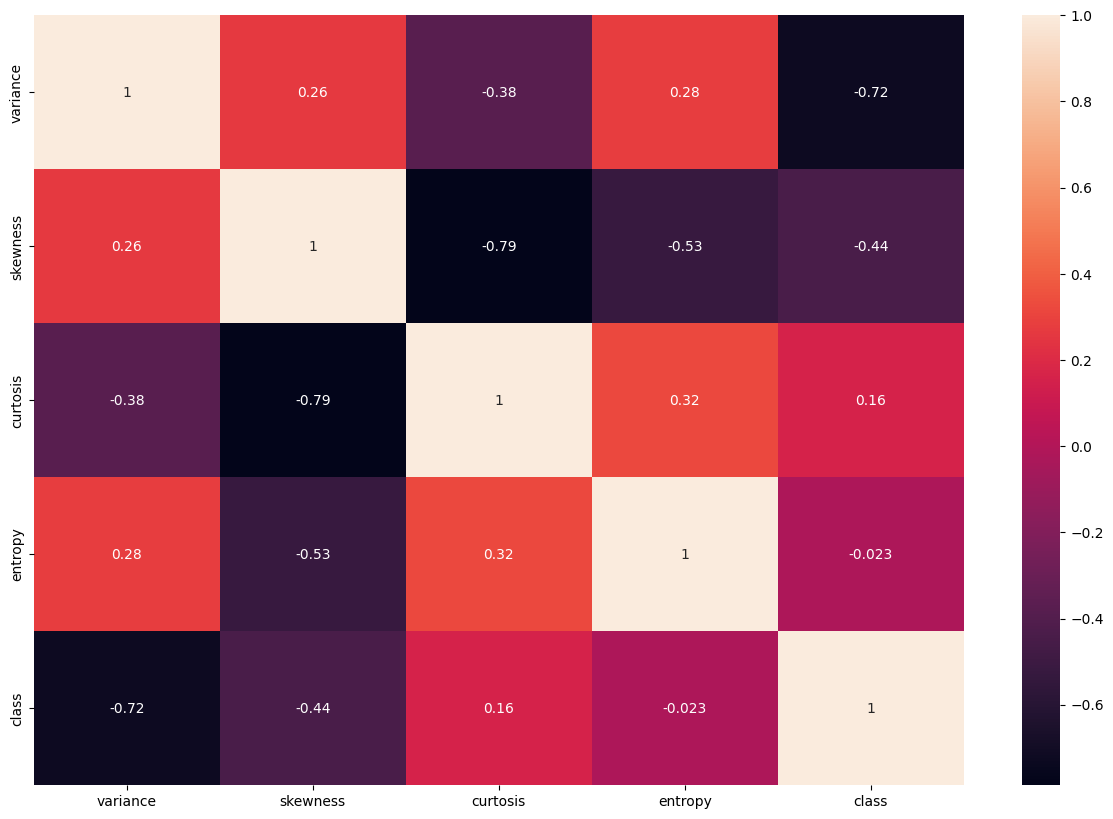

In [28]:
# Matriz de correlación
plt.figure(figsize=(15,10))
corr = banknote.select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True)
plt.show()

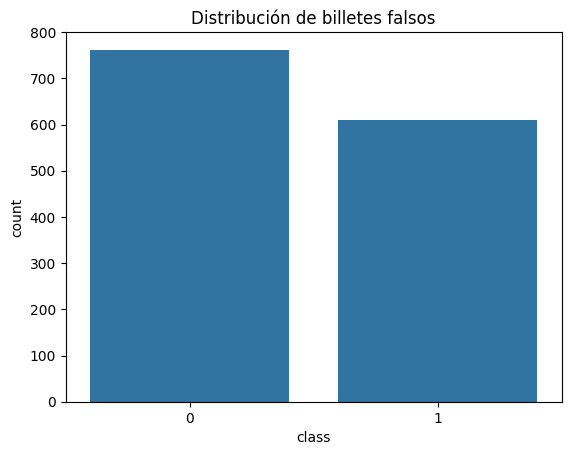

In [29]:
# Distribución de billetes falsos
sns.countplot(x='class', data=banknote)
plt.title('Distribución de billetes falsos')
plt.show()

### 3. Escalar datos

In [30]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 4. Reducción de la dimensionalidad

#### 4.1 PCA
Para explorar la estructura interna del dataset y facilitar su análisis visual, se aplicó Análisis de Componentes Principales (PCA).
De esta forma podemos reducir la dimensionalidad a dos dimensiones del conjunto de datos, manteniendo la mayor parte posible de la información (varianza)

In [31]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

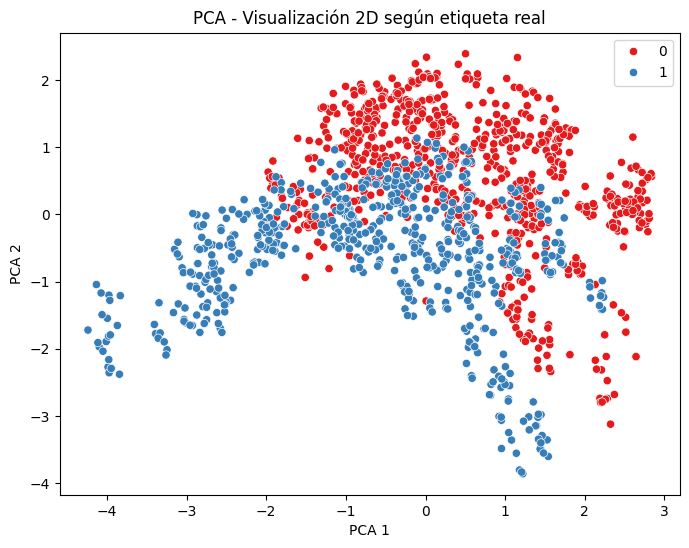

In [32]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y.iloc[:, 0].values, palette='Set1')
plt.title('PCA - Visualización 2D según etiqueta real')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [33]:
# Varianza explicada por los componentes principales
print("Varianza explicada por cada componente:", pca.explained_variance_ratio_)
print("Varianza total explicada:", format(sum(pca.explained_variance_ratio_), '.3f'))

Varianza explicada por cada componente: [0.54497602 0.32328872]
Varianza total explicada: 0.868


Tras aplicar PCA, los dos componentes resultantes explican aproximadamente el 86.8% de la varianza total del dataset.
Esto indica que la proyección conserva una gran parte de la información original, haciendo viable su uso para visualización sin una pérdida significativa de datos relevantes.

#### 4.2 t-SNE

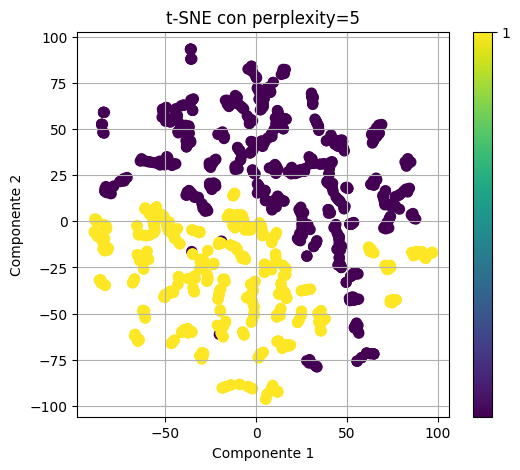

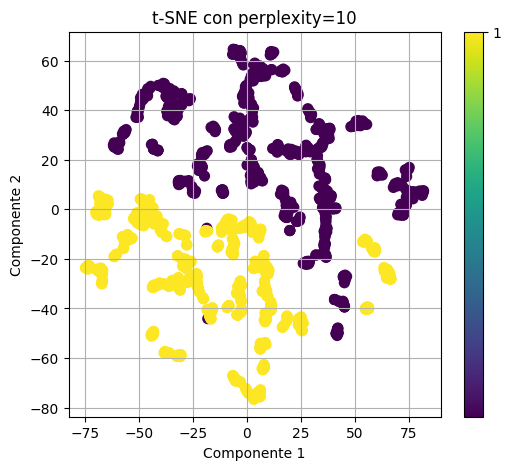

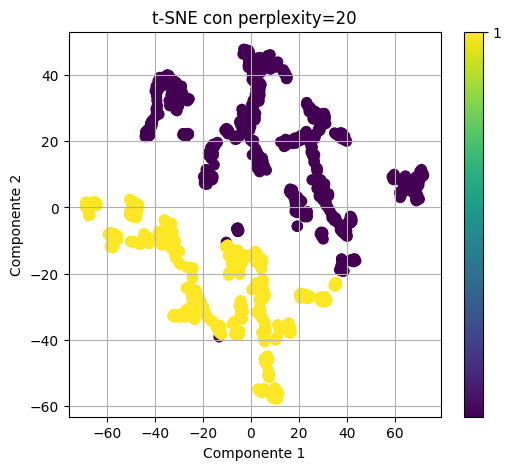

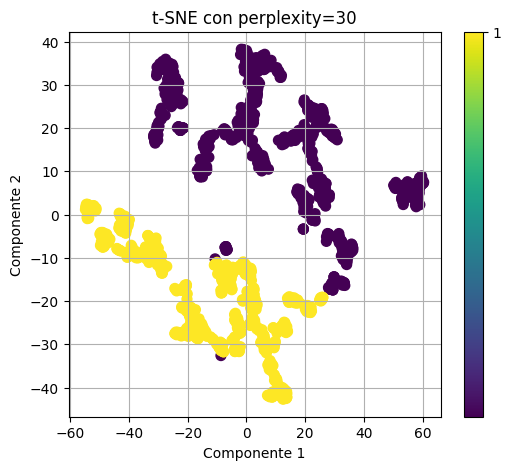

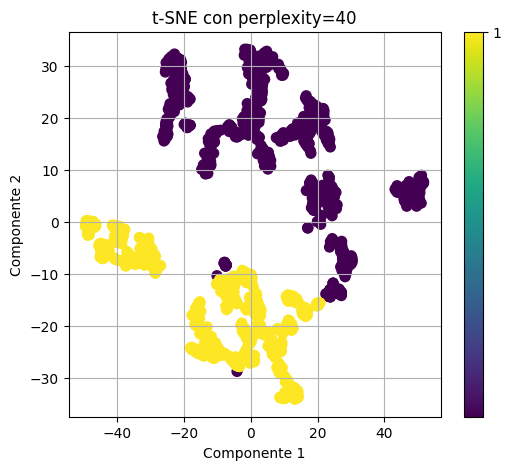

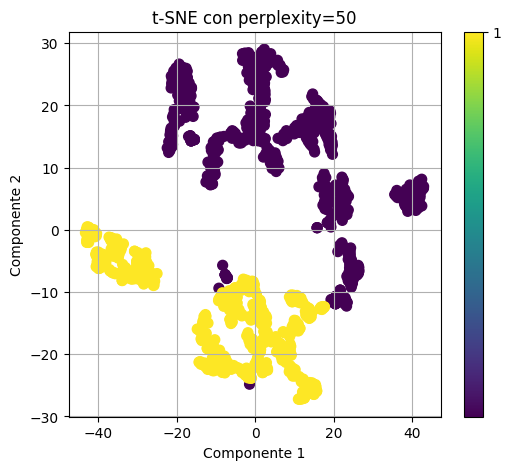

In [34]:
perplexities = [5, 10, 20, 30, 40, 50]

for p in perplexities:
    tsne = TSNE(n_components=2, perplexity=p, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)

    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y.iloc[:, 0].values, cmap='viridis', s=50)
    plt.title(f't-SNE con perplexity={p}')
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.colorbar(scatter, ticks=[1, 2, 3])
    plt.grid(True)
    plt.show()

Para evaluar qué tan bien t-SNE conserva la estructura local del dataset, se optó por una evaluación visual, observando la distribución y agrupación de los datos proyectados en 2D.

Tras probar distintos valores de perplexity, se encontró que 30 ofrecía una buena separación entre grupos y una representación clara de las vecindades. Si bien valores más altos ofrecían una leve mejora en la continuidad global, perplexity = 30 logró un buen equilibrio entre detalle local y estabilidad visual, por lo que fue elegido como valor final para el análisis.

In [35]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

## 5. Clustering

Métricas externas para la evaluación de clustering:
1. **adjusted_rand_score (ARI):** Qué tan similares son dos asignaciones de clusters (la real vs. la predicha)
2. **adjusted_mutual_info_score (AMI):** Cuánta información comparten las etiquetas reales y los clusters predichos
3. **homogeneity_score:** Si cada cluster predicho contiene solo datos de una clase.
4. **completeness_score:** Si todos los datos de una clase real están dentro del mismo cluster
5. **v_measure_score:** La media armónica entre homogeneity y completeness

Métrica interna para la evaluación de clustering:
- **silhouette_score:** Evalúa qué tan bien separados y compactos están los clusters sin necesidad de conocer las etiquetas reales

### 5.1 K-Means

In [36]:
kmeans_pca = KMeans(n_clusters=2, random_state=123).fit(X_pca)
clusters_kmeans = kmeans_pca.fit_predict(X_pca)
kmeans_tsne = KMeans(n_clusters=2, random_state=123).fit(X_tsne)
clusters_kmeans = kmeans_tsne.fit_predict(X_tsne)

In [37]:
# Silhouette score
sil_pca = silhouette_score(X_pca, kmeans_pca.labels_)
sil_tsne = silhouette_score(X_tsne, kmeans_tsne.labels_)

# Métricas externas PCA
ari = adjusted_rand_score(y.iloc[:, 0], kmeans_pca.labels_)
ami = adjusted_mutual_info_score(y.iloc[:, 0], kmeans_pca.labels_)
hom = homogeneity_score(y.iloc[:, 0], kmeans_pca.labels_)
comp = completeness_score(y.iloc[:, 0], kmeans_pca.labels_)
v_measure = v_measure_score(y.iloc[:, 0], kmeans_pca.labels_)

# Métricas externas t-SNE
ari = adjusted_rand_score(y.iloc[:, 0], kmeans_tsne.labels_)
ami = adjusted_mutual_info_score(y.iloc[:, 0], kmeans_tsne.labels_)
hom = homogeneity_score(y.iloc[:, 0], kmeans_tsne.labels_)
comp = completeness_score(y.iloc[:, 0], kmeans_tsne.labels_)
v_measure = v_measure_score(y.iloc[:, 0], kmeans_tsne.labels_)

print("PCA")
print(f"Silhouette PCA: {sil_pca:.3f}")
print("Comparación con etiquetas reales:")
print(f"Adjusted Rand Index (ARI): {ari:.3f}")
print(f"Adjusted Mutual Information (AMI): {ami:.3f}")
print(f"Homogeneity: {hom:.3f}")
print(f"Completeness: {comp:.3f}")
print(f"V-measure: {v_measure:.3f}")

print("\nt-SNE")
print(f"Silhouette t-SNE: {sil_tsne:.3f}")
print("Comparación con etiquetas reales:")
print(f"Adjusted Rand Index (ARI): {ari:.3f}")
print(f"Adjusted Mutual Information (AMI): {ami:.3f}")
print(f"Homogeneity: {hom:.3f}")
print(f"Completeness: {comp:.3f}")
print(f"V-measure: {v_measure:.3f}")

PCA
Silhouette PCA: 0.391
Comparación con etiquetas reales:
Adjusted Rand Index (ARI): 0.135
Adjusted Mutual Information (AMI): 0.096
Homogeneity: 0.096
Completeness: 0.096
V-measure: 0.096

t-SNE
Silhouette t-SNE: 0.354
Comparación con etiquetas reales:
Adjusted Rand Index (ARI): 0.135
Adjusted Mutual Information (AMI): 0.096
Homogeneity: 0.096
Completeness: 0.096
V-measure: 0.096


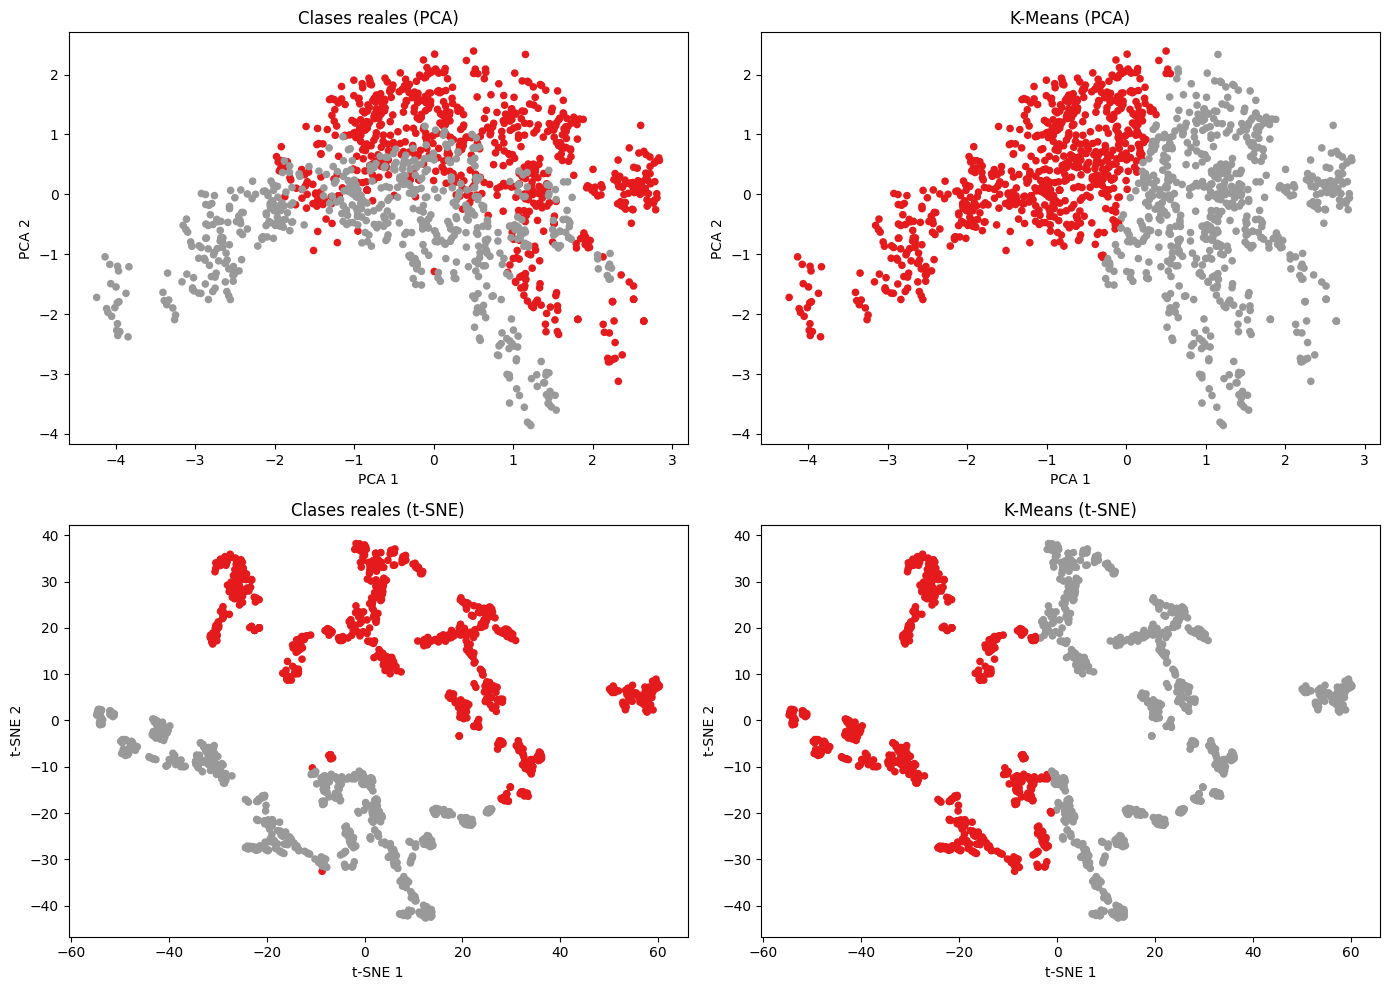

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Clases reales en PCA
axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=banknote['class'], cmap='Set1', s=20)
axes[0, 0].set_title("Clases reales (PCA)")
axes[0, 0].set_xlabel("PCA 1")
axes[0, 0].set_ylabel("PCA 2")

# 2. K-Means sobre PCA
axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_pca.labels_, cmap='Set1', s=20)
axes[0, 1].set_title("K-Means (PCA)")
axes[0, 1].set_xlabel("PCA 1")
axes[0, 1].set_ylabel("PCA 2")

# 3. Clases reales en t-SNE
axes[1, 0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=banknote['class'], cmap='Set1', s=20)
axes[1, 0].set_title("Clases reales (t-SNE)")
axes[1, 0].set_xlabel("t-SNE 1")
axes[1, 0].set_ylabel("t-SNE 2")

# 4. K-Means sobre t-SNE
axes[1, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_tsne.labels_, cmap='Set1', s=20)
axes[1, 1].set_title("K-Means (t-SNE)")
axes[1, 1].set_xlabel("t-SNE 1")
axes[1, 1].set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()

Ni PCA ni t-SNE lograron una separación clara de clases que K-Means pudiera recuperar.
Aunque PCA tuvo un ligeramente mejor silhouette score, en ambos casos los clusters no coinciden bien con las clases reales. Por lo tantro, K-Means puede no ser el método más adecuado para este problema.

### 5.2 DBSCAN

In [39]:
eps_values = np.linspace(1.0, 3.5, 20, 30)
min_samples_values = range(3, 10)

best_score = -1
best_params = None
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_tsne)
        labels = db.labels_

        if len(set(labels)) <= 1 or (set(labels) == {-1}):
            continue

        score = adjusted_rand_score(y.iloc[:, 0], labels)
        results.append((eps, min_samples, score))

        if score > best_score:
            best_score = score
            best_params = (eps, min_samples)

if best_params is not None:
    print(f"Mejor ARI Score: {best_score:.3f}")
    print(f"Mejores parámetros: eps = {best_params[0]:.2f}, min_samples = {best_params[1]}")
else:
    print("No se encontraron parámetros válidos que generen más de un cluster.")

Mejor ARI Score: 0.298
Mejores parámetros: eps = 3.50, min_samples = 3


In [40]:
dbscan_pca = DBSCAN(eps=best_params[0], min_samples=best_params[1]).fit(X_tsne)
clusters_dbscan = dbscan_pca.fit_predict(X_tsne)

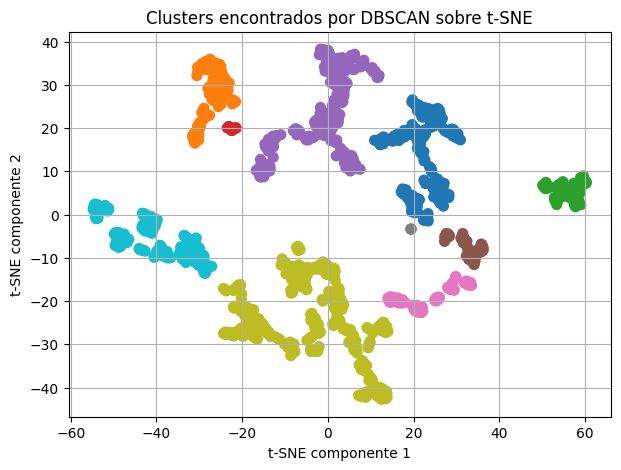

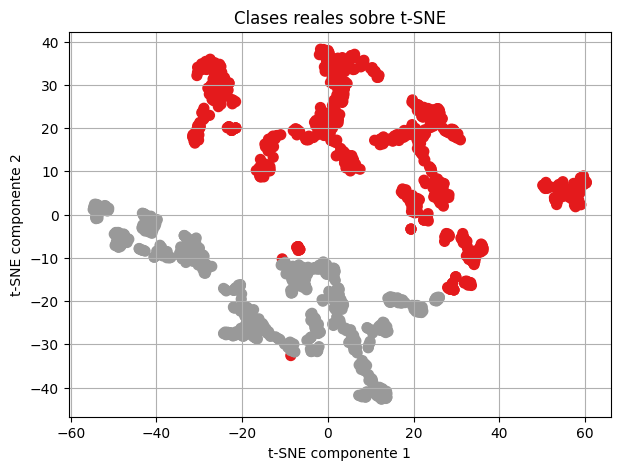

In [41]:
plt.figure(figsize=(7, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters_dbscan, cmap='tab10', s=50)
plt.title("Clusters encontrados por DBSCAN sobre t-SNE")
plt.xlabel("t-SNE componente 1")
plt.ylabel("t-SNE componente 2")
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=banknote['class'], cmap='Set1', s=50)
plt.title("Clases reales sobre t-SNE")
plt.xlabel("t-SNE componente 1")
plt.ylabel("t-SNE componente 2")
plt.grid(True)
plt.show()

El valor alto de Homogeneity (0.89) indica que cada cluster contiene principalmente una sola clase, lo que sugiere buena separación interna.

Sin embargo, Completeness (0.305) revela que una misma clase está dividida en múltiples clusters, lo que reduce la utilidad práctica del agrupamiento.

La métrica ARI (0.298) muestra una ligera mejora al representar la similitud entre los billetes reales y los predichos en comparación a K-Means

Por lo tanto, podríamos decir que DBSCAN sobre t-SNE resultó ser mas adecuado que K-Means en este contexto, ya que encaja mejor con la estructura observada visualmente en los datos proyectados por t-SNE

### 5.3 AgglomerativeClustering

Ulizamos  el criterio **Ward**, ya que este ayuda a decidir qué grupos unir en cada paso del algoritmo. minimizando el aumento de la varianza total dentro de los clústeres. Y es que, como se vio con DBSCAN, existen diversos clusters dentro de una categoría, por lo que, con este criterio se podrían "juntar" y así obtener el resultado esperado.

In [42]:
agglo = AgglomerativeClustering(n_clusters=2, linkage='ward')
labels = agglo.fit_predict(X_tsne)

In [43]:
# Métricas internas
sil_score = silhouette_score(X_tsne, labels)
print(f"Silhouette Score: {sil_score:.3f}")

# Métricas externas
ari = adjusted_rand_score(y.iloc[:, 0], labels)
ami = adjusted_mutual_info_score(y.iloc[:, 0], labels)
hom = homogeneity_score(y.iloc[:, 0], labels)
comp = completeness_score(y.iloc[:, 0], labels)
v_measure = v_measure_score(y.iloc[:, 0], labels)

print("\nComparación con etiquetas reales:")
print(f"Adjusted Rand Index (ARI): {ari:.3f}")
print(f"Adjusted Mutual Information (AMI): {ami:.3f}")
print(f"Homogeneity: {hom:.3f}")
print(f"Completeness: {comp:.3f}")
print(f"V-measure: {v_measure:.3f}")

Silhouette Score: 0.378

Comparación con etiquetas reales:
Adjusted Rand Index (ARI): 0.827
Adjusted Mutual Information (AMI): 0.744
Homogeneity: 0.740
Completeness: 0.748
V-measure: 0.744


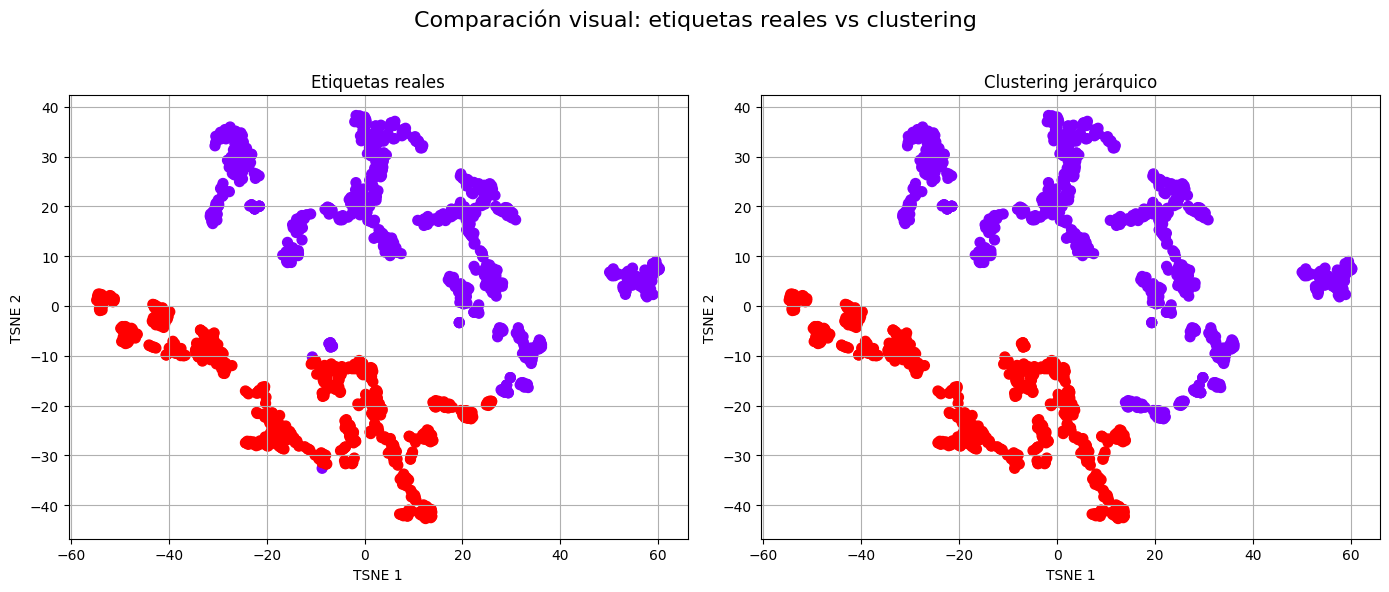

In [44]:
# Visualización: Real vs Clustering
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Etiquetas reales
axs[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y.iloc[:, 0], cmap='rainbow', s=50)
axs[0].set_title("Etiquetas reales")
axs[0].set_xlabel("TSNE 1")
axs[0].set_ylabel("TSNE 2")
axs[0].grid(True)

# Etiquetas del clustering
axs[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='rainbow', s=50)
axs[1].set_title("Clustering jerárquico")
axs[1].set_xlabel("TSNE 1")
axs[1].set_ylabel("TSNE 2")
axs[1].grid(True)

plt.suptitle("Comparación visual: etiquetas reales vs clustering", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Podemos observar como el clustering jerárquico aglomerativo aplicado sobre t-SNE arrojó resultados notablemente mejores que K-Means y DBSCAN, con un ARI de 0.827 y una AMI de 0.744, lo que indica una alta concordancia con las clases reales. Las métricas de homogeneidad (0.740), completitud (0.748) y V-measure (0.744) reflejan que los clústeres generados son internamente consistentes y capturan gran parte de la estructura verdadera del conjunto de datos. A diferencia de DBSCAN, que depende fuertemente de parámetros como eps, o K-Means, que asume formas esféricas, el uso de Ward permite detectar agrupamientos bien definidos sobre la estructura local preservada por t-SNE